In [1]:
import keras
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Layer
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_yaml
from modAL.models import ActiveLearner
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.backend import eager_learning_phase_scope
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import math, os
import torchvision

from torch.utils.data import DataLoader
from keras.layers import MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D

In [2]:
# dataset preparation
def load_dataset(batch_size = 128, root = '.\datasets'):
    train_dataset = torchvision.datasets.MNIST(root = root + '\MNIST', train=True, 
                                               transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(root = root + '\MNIST', train=False, 
                                              transform=transforms.ToTensor())
   
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [3]:
mnist_train, mnist_test = load_dataset()

In [4]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype(np.float32)) / 255.
X_train = X_train.reshape(X_train.shape[0], -1)

X_test = (X_test.astype(np.float32)) / 255.
X_test = X_test.reshape(X_test.shape[0], -1)

In [6]:
BATCH_SIZE = 256
ORIGINAL_DIM = 784
HIDDEN_DIM = 512
EPOCH = 5
epsilon_std = 1.0
#LATENT_DIMS = [2, 4, 8, 16, 32, 64, 128, 256, 512]
LATENT_DIM = 64
usecuda=False
USE_CUDA = False
DEVICE   = ('cuda' if USE_CUDA else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class BIGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the encoder
        self.encoder = self.build_encoder()

        # The part of the bigan that trains the discriminator and encoder
        self.discriminator.trainable = False

        # Generate image from sampled noise
        z = Input(shape=(LATENT_DIM, ))
        img_ = self.generator(z)

        # Encode image
        img = Input(shape=ORIGINAL_DIM)
        z_ = self.encoder(img)

        # Latent -> img is fake, and img -> latent is valid
        fake = self.discriminator([z, img_])
        valid = self.discriminator([z_, img])

        # Set up and compile the combined model
        # Trains generator to fool the discriminator
        self.bigan_generator = Model([z, img], [fake, valid])
        self.bigan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            optimizer=optimizer)
        
    def build_encoder(self):
        model = Sequential()

        model.add(Dense(HIDDEN_DIM))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(HIDDEN_DIM//2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(LATENT_DIM))

        img = Input(shape=ORIGINAL_DIM)
        z = model(img)

        return Model(img, z)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(HIDDEN_DIM//2, input_dim=LATENT_DIM))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(HIDDEN_DIM))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.prod(ORIGINAL_DIM), activation='sigmoid'))

        z = Input(shape=(LATENT_DIM,))
        gen_img = model(z)

        return Model(z, gen_img)
    def build_discriminator(self):

        z = Input(shape=(LATENT_DIM, ))
        img = Input(shape=ORIGINAL_DIM)
        d_in = concatenate([z, Flatten()(img)])

        model = Dense(HIDDEN_DIM)(d_in)
        model = ReLU()(model)
        model = Dropout(0.5)(model)
        model = Dense(HIDDEN_DIM)(model)
        model = ReLU()(model)
        model = Dropout(0.5)(model)
        model = Dense(HIDDEN_DIM)(model)
        model = ReLU()(model)
        model = Dropout(0.5)(model)
        validity = Dense(1, activation="sigmoid")(model)

        return Model([z, img], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
    
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32)) / 255.
        X_train = X_train.reshape(X_train.shape[0], -1)

        # Adversarial ground truths
        
        
        n_show = 10

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            train_indices = np.arange(0, X_train.shape[0])
            np.random.shuffle(train_indices)
            for i in range(0, len(X_train), batch_size): 
                end = i + batch_size
                if (end > len(X_train)):
                    end = len(X_train)
            # Sample noise and generate img
                imgs = X_train[train_indices[i:end]]
                z_ = self.encoder.predict(imgs)
                
                valid = np.ones((imgs.shape[0], 1))
                fake = np.zeros((imgs.shape[0], 1))
            
                z = np.random.normal(size=(imgs.shape[0], LATENT_DIM))
                imgs_ = self.generator.predict(z)

                # Select a random batch of images and encode
                #idx = np.random.randint(0, X_train.shape[0], batch_size)
                
                # Train the discriminator (img -> z is valid, z -> img is fake)
                d_loss_real = self.discriminator.train_on_batch([z_, imgs], valid)
                d_loss_fake = self.discriminator.train_on_batch([z, imgs_], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator (z -> img is valid and img -> z is is invalid)
                g_loss = self.bigan_generator.train_on_batch([z, imgs], [valid, fake])

                # Plot the progress
            
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
            
            gener = imgs_[:n_show].reshape(n_show, 28, 28)
            fig, ax = plt.subplots(1, n_show, figsize=(15,5))
            for i in range(n_show):
                ax[i].imshow(gener[i], cmap='gray')
                ax[i].axis('off')
            plt.show()

Instructions for updating:
Colocations handled automatically by placer.


c:\users\pinar\onedrive\masaüstü\masterthesis\msthesisenv\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0 [D loss: 0.355441, acc: 83.33%] [G loss: 5.384721]


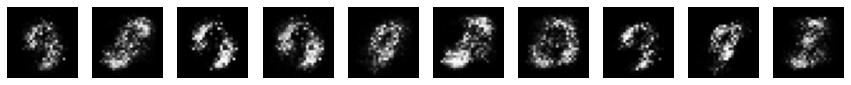

1 [D loss: 0.285532, acc: 88.54%] [G loss: 4.858024]


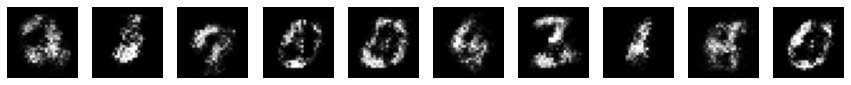

2 [D loss: 0.278764, acc: 89.58%] [G loss: 5.239187]


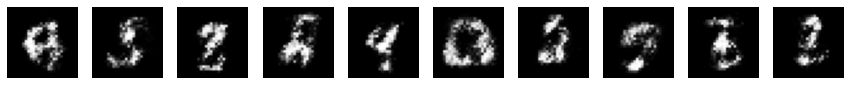

3 [D loss: 0.228725, acc: 91.15%] [G loss: 5.507455]


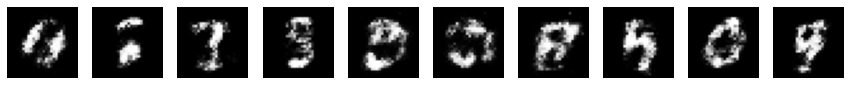

4 [D loss: 0.327078, acc: 80.73%] [G loss: 4.573924]


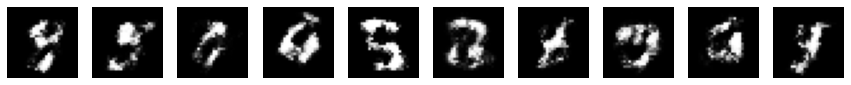

5 [D loss: 0.213847, acc: 89.58%] [G loss: 6.234556]


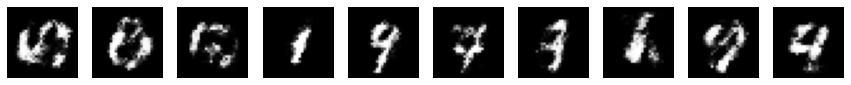

6 [D loss: 0.330741, acc: 84.90%] [G loss: 5.397280]


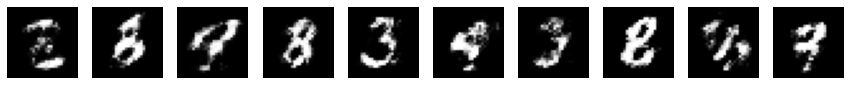

7 [D loss: 0.300344, acc: 88.02%] [G loss: 5.202273]


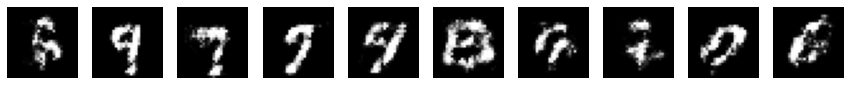

8 [D loss: 0.355515, acc: 82.81%] [G loss: 4.925779]


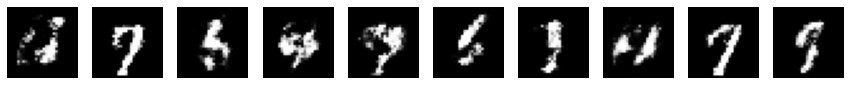

9 [D loss: 0.347579, acc: 84.38%] [G loss: 4.753252]


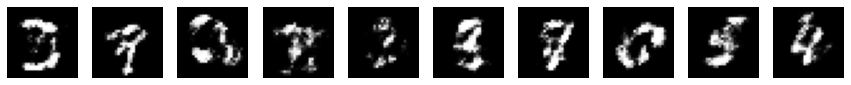

10 [D loss: 0.375440, acc: 82.81%] [G loss: 5.787672]


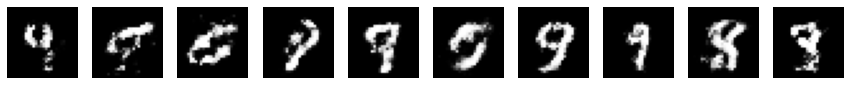

11 [D loss: 0.347306, acc: 84.90%] [G loss: 4.899342]


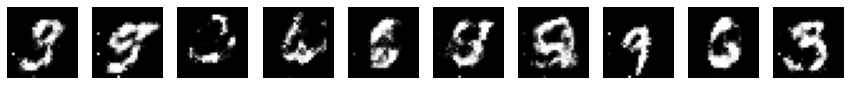

12 [D loss: 0.356914, acc: 86.46%] [G loss: 4.880080]


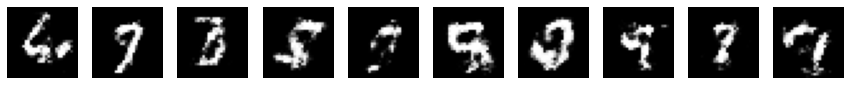

13 [D loss: 0.460205, acc: 75.00%] [G loss: 4.810727]


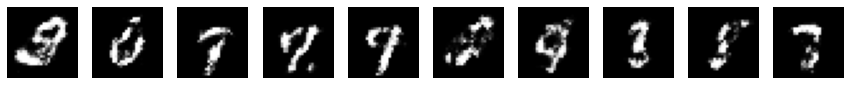

14 [D loss: 0.358687, acc: 85.42%] [G loss: 4.586352]


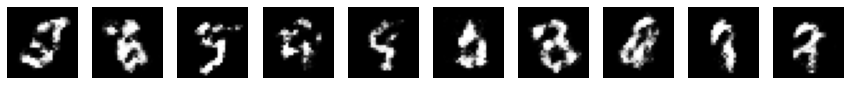

15 [D loss: 0.425235, acc: 80.21%] [G loss: 4.105222]


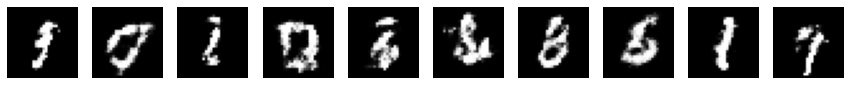

16 [D loss: 0.408427, acc: 80.73%] [G loss: 4.401304]


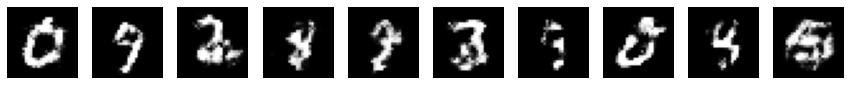

17 [D loss: 0.357810, acc: 85.42%] [G loss: 4.626412]


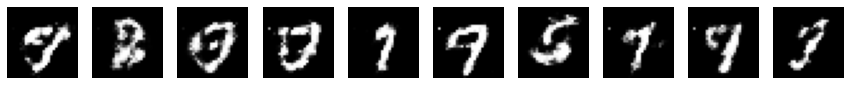

18 [D loss: 0.385820, acc: 80.21%] [G loss: 4.418480]


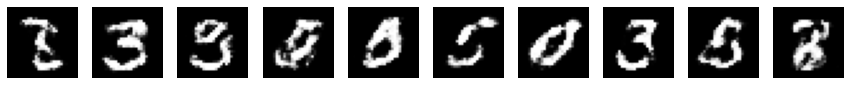

19 [D loss: 0.443106, acc: 80.21%] [G loss: 4.146439]


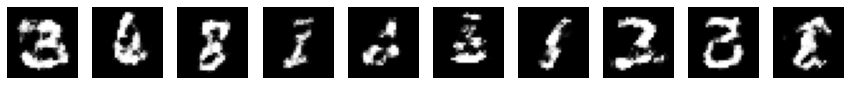

20 [D loss: 0.464470, acc: 75.52%] [G loss: 4.205716]


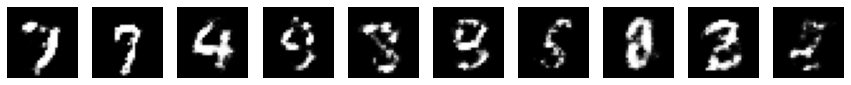

21 [D loss: 0.474044, acc: 77.60%] [G loss: 4.386509]


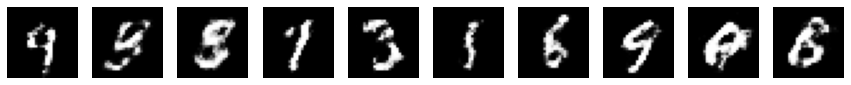

22 [D loss: 0.447835, acc: 77.60%] [G loss: 4.412471]


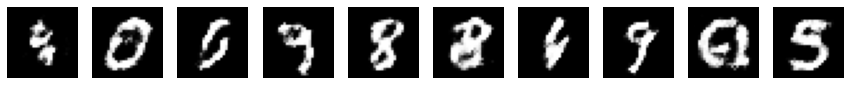

23 [D loss: 0.390949, acc: 80.73%] [G loss: 4.356014]


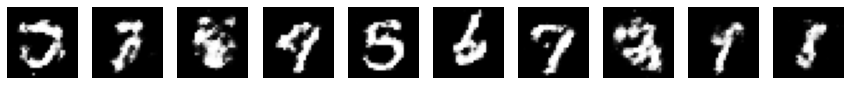

24 [D loss: 0.503088, acc: 75.00%] [G loss: 4.127811]


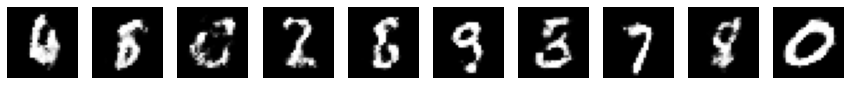

25 [D loss: 0.384737, acc: 84.38%] [G loss: 4.574931]


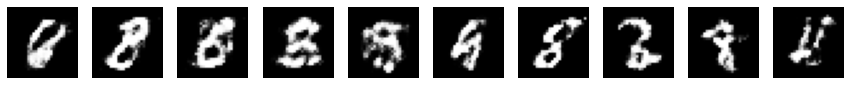

26 [D loss: 0.368820, acc: 83.33%] [G loss: 4.073318]


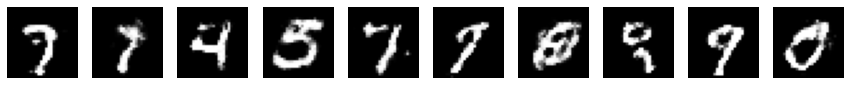

27 [D loss: 0.429702, acc: 79.17%] [G loss: 4.211333]


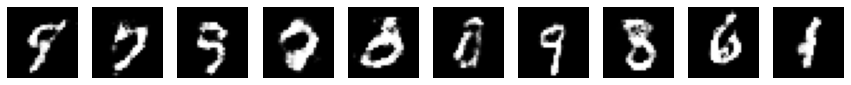

28 [D loss: 0.454086, acc: 78.65%] [G loss: 3.976058]


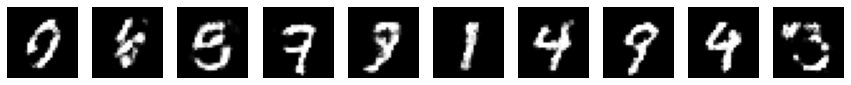

29 [D loss: 0.441326, acc: 82.81%] [G loss: 4.476647]


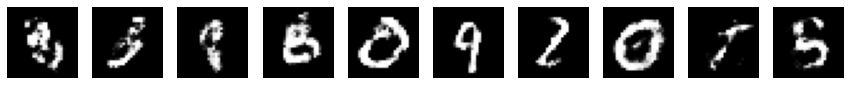

30 [D loss: 0.400706, acc: 80.73%] [G loss: 4.179270]


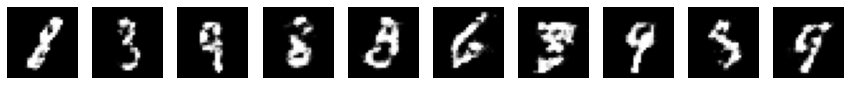

31 [D loss: 0.398588, acc: 79.69%] [G loss: 4.587520]


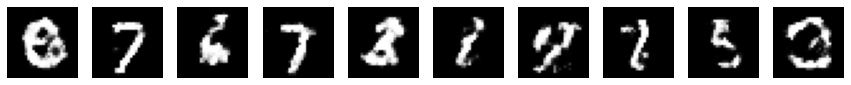

32 [D loss: 0.437511, acc: 75.00%] [G loss: 4.261375]


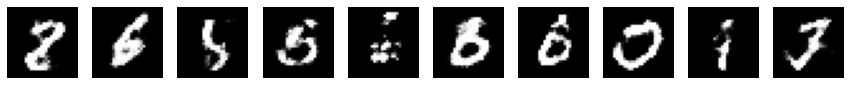

33 [D loss: 0.374085, acc: 83.85%] [G loss: 4.211286]


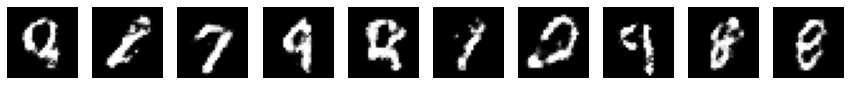

34 [D loss: 0.446163, acc: 78.12%] [G loss: 4.287233]


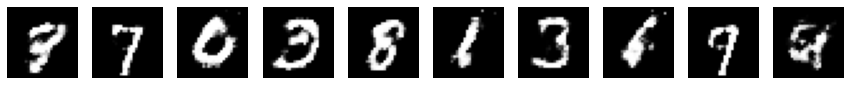

35 [D loss: 0.410946, acc: 78.65%] [G loss: 4.332015]


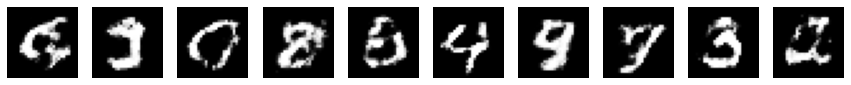

36 [D loss: 0.422131, acc: 79.69%] [G loss: 4.260733]


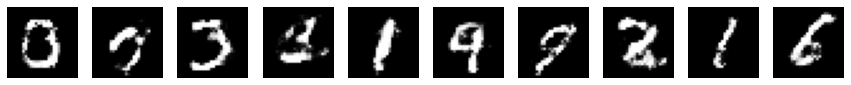

37 [D loss: 0.474841, acc: 78.65%] [G loss: 4.071224]


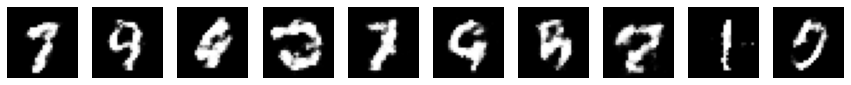

38 [D loss: 0.396013, acc: 83.33%] [G loss: 3.882108]


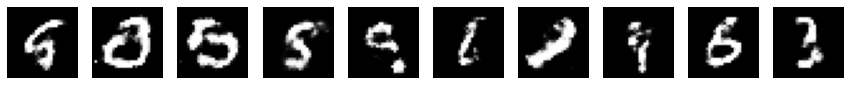

39 [D loss: 0.573637, acc: 70.31%] [G loss: 3.681600]


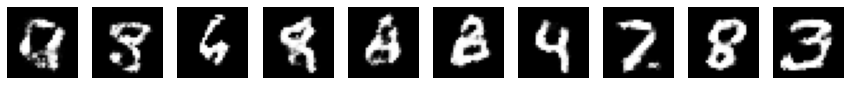

40 [D loss: 0.404954, acc: 82.29%] [G loss: 3.942285]


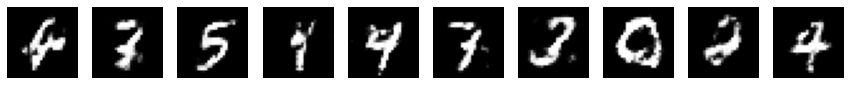

41 [D loss: 0.429721, acc: 80.73%] [G loss: 4.686008]


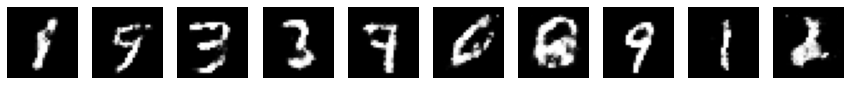

42 [D loss: 0.413652, acc: 76.56%] [G loss: 4.336023]


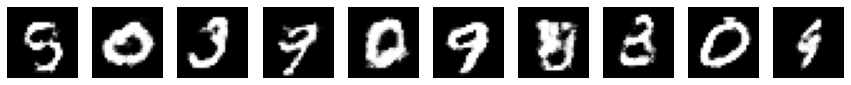

43 [D loss: 0.454131, acc: 80.73%] [G loss: 4.705244]


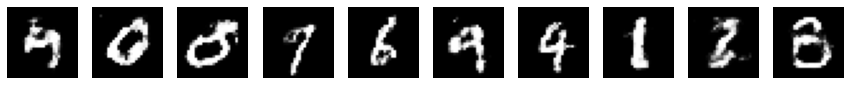

44 [D loss: 0.473811, acc: 77.60%] [G loss: 4.025229]


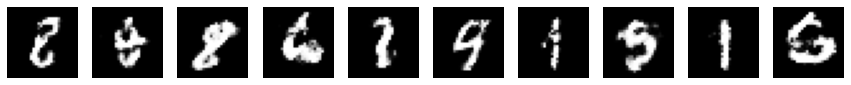

45 [D loss: 0.409130, acc: 84.38%] [G loss: 3.915054]


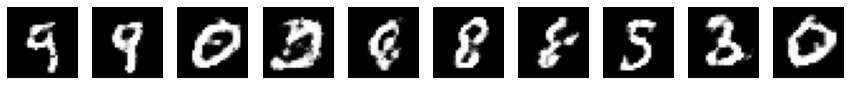

46 [D loss: 0.426714, acc: 82.29%] [G loss: 4.083233]


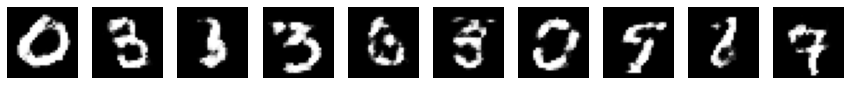

47 [D loss: 0.465742, acc: 77.08%] [G loss: 4.528639]


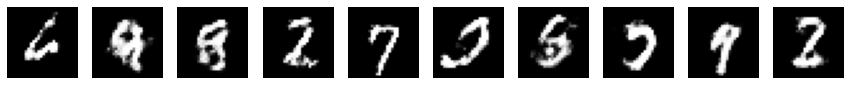

48 [D loss: 0.448049, acc: 81.77%] [G loss: 3.909634]


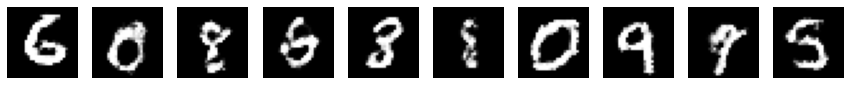

49 [D loss: 0.481768, acc: 77.60%] [G loss: 4.018037]


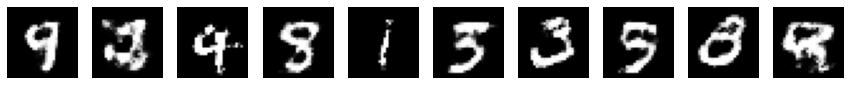

50 [D loss: 0.450281, acc: 75.00%] [G loss: 3.898103]


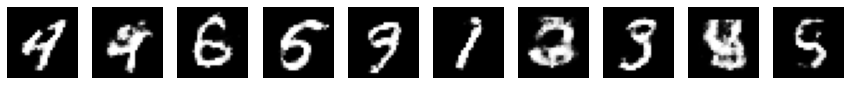

51 [D loss: 0.495557, acc: 76.56%] [G loss: 3.756722]


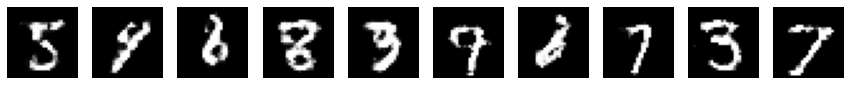

52 [D loss: 0.430486, acc: 79.69%] [G loss: 4.080749]


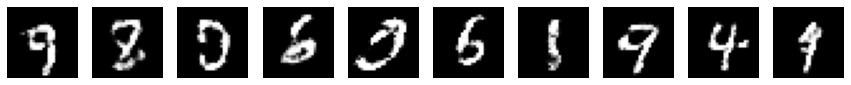

53 [D loss: 0.437563, acc: 78.65%] [G loss: 4.125000]


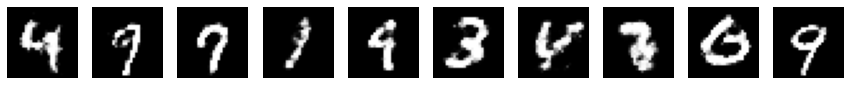

54 [D loss: 0.406795, acc: 83.85%] [G loss: 4.076340]


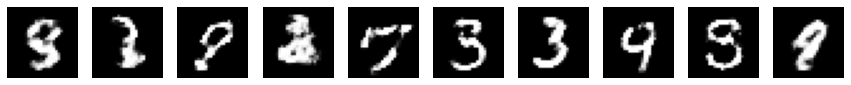

55 [D loss: 0.421662, acc: 81.77%] [G loss: 3.983908]


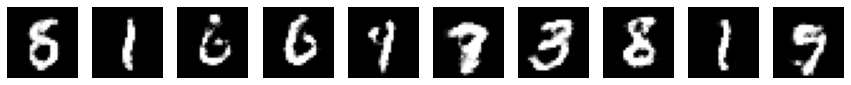

56 [D loss: 0.445953, acc: 77.60%] [G loss: 3.881329]


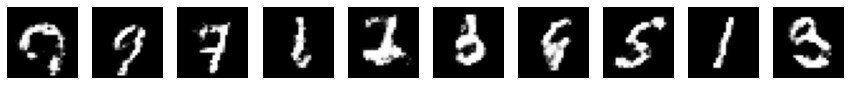

57 [D loss: 0.507296, acc: 76.56%] [G loss: 4.234679]


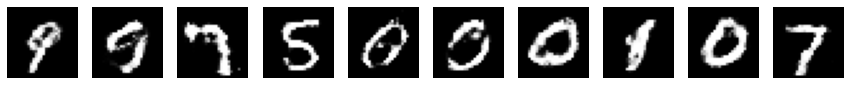

58 [D loss: 0.370180, acc: 82.29%] [G loss: 4.451819]


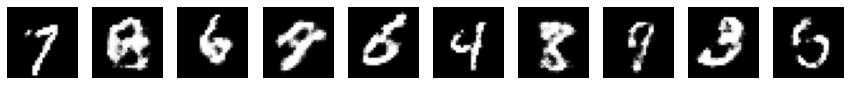

59 [D loss: 0.470608, acc: 77.60%] [G loss: 3.999379]


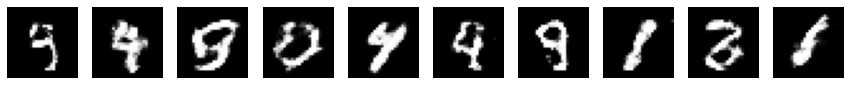

60 [D loss: 0.414612, acc: 80.73%] [G loss: 4.008711]


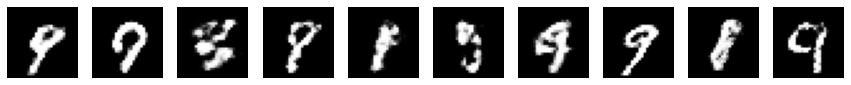

61 [D loss: 0.389452, acc: 83.33%] [G loss: 4.542968]


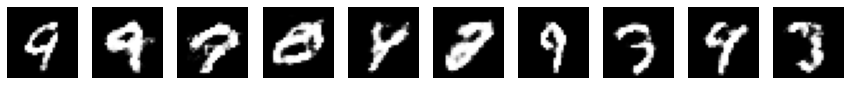

62 [D loss: 0.500372, acc: 78.65%] [G loss: 4.268675]


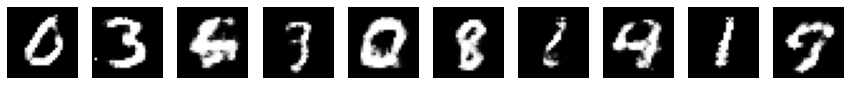

63 [D loss: 0.371555, acc: 83.33%] [G loss: 4.670339]


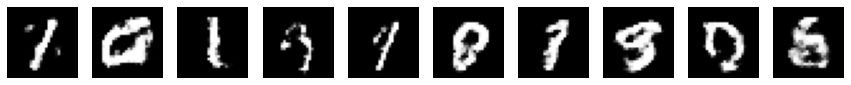

64 [D loss: 0.398873, acc: 80.21%] [G loss: 4.545966]


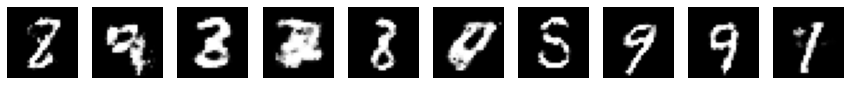

65 [D loss: 0.439570, acc: 81.25%] [G loss: 3.800362]


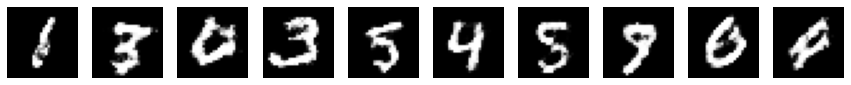

66 [D loss: 0.438253, acc: 79.69%] [G loss: 4.224127]


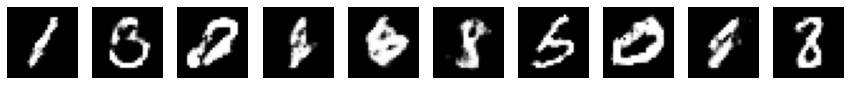

67 [D loss: 0.487896, acc: 80.21%] [G loss: 4.115988]


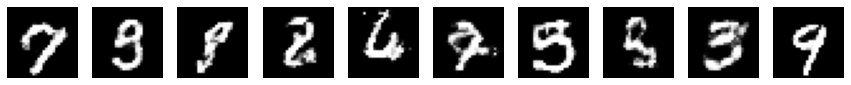

68 [D loss: 0.441871, acc: 80.21%] [G loss: 4.192383]


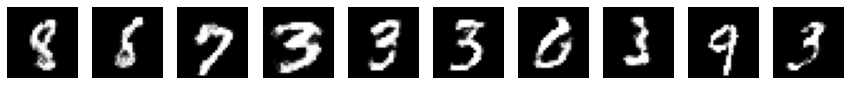

69 [D loss: 0.429309, acc: 76.04%] [G loss: 4.305484]


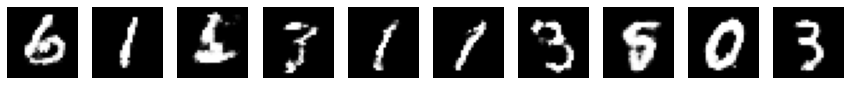

70 [D loss: 0.461752, acc: 76.56%] [G loss: 3.945744]


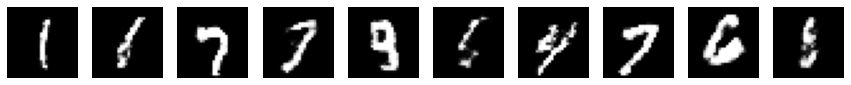

71 [D loss: 0.453131, acc: 77.60%] [G loss: 4.100185]


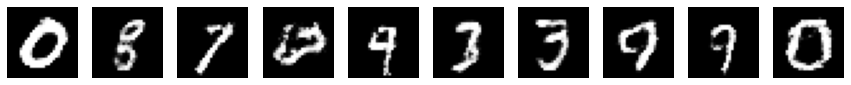

72 [D loss: 0.432215, acc: 78.65%] [G loss: 4.059754]


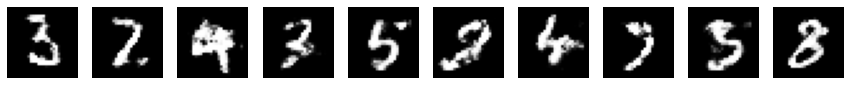

73 [D loss: 0.437959, acc: 78.65%] [G loss: 3.863788]


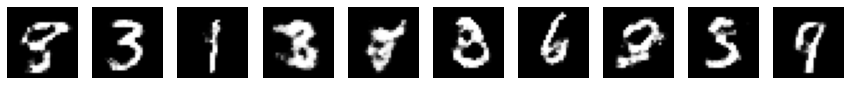

74 [D loss: 0.401867, acc: 79.69%] [G loss: 4.659318]


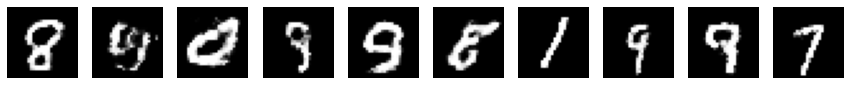

75 [D loss: 0.455585, acc: 79.17%] [G loss: 4.081846]


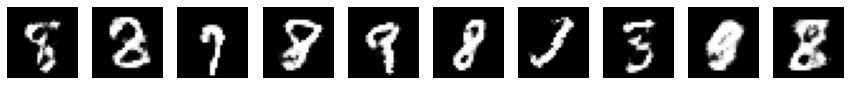

76 [D loss: 0.545834, acc: 75.52%] [G loss: 4.509775]


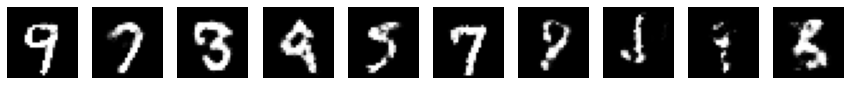

77 [D loss: 0.370696, acc: 84.38%] [G loss: 4.917758]


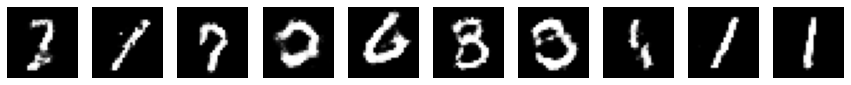

78 [D loss: 0.446196, acc: 77.60%] [G loss: 4.506449]


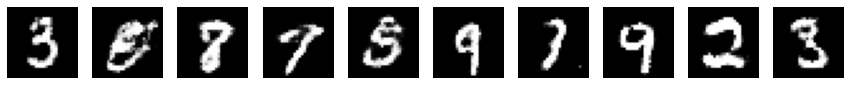

79 [D loss: 0.502438, acc: 76.56%] [G loss: 4.405988]


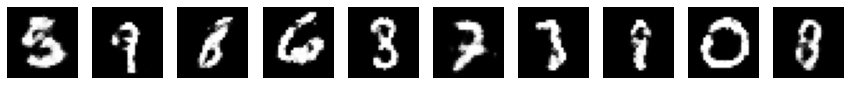

80 [D loss: 0.457969, acc: 77.08%] [G loss: 4.146292]


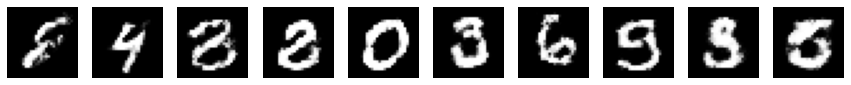

81 [D loss: 0.390987, acc: 82.81%] [G loss: 4.488363]


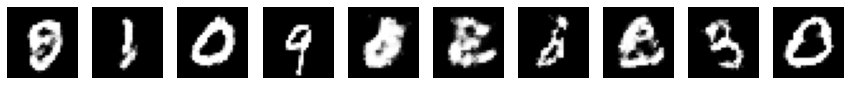

82 [D loss: 0.407422, acc: 83.33%] [G loss: 4.179474]


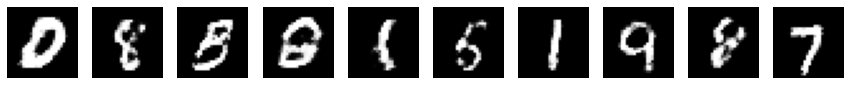

83 [D loss: 0.477685, acc: 78.12%] [G loss: 4.247333]


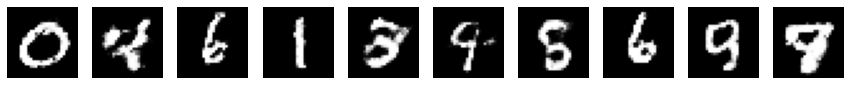

84 [D loss: 0.361295, acc: 85.94%] [G loss: 4.121839]


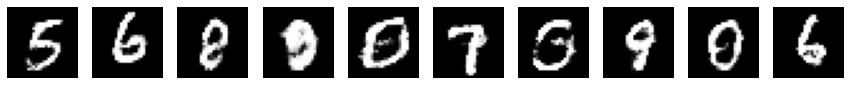

85 [D loss: 0.433931, acc: 81.25%] [G loss: 4.002403]


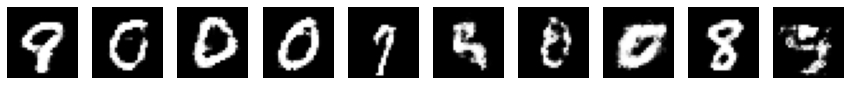

86 [D loss: 0.437203, acc: 78.65%] [G loss: 3.981557]


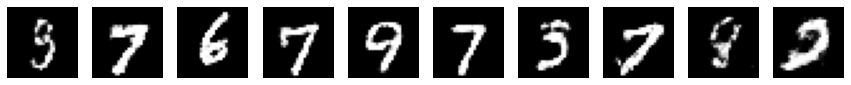

87 [D loss: 0.416880, acc: 81.25%] [G loss: 4.792420]


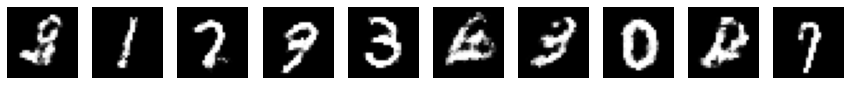

88 [D loss: 0.411099, acc: 81.77%] [G loss: 3.867028]


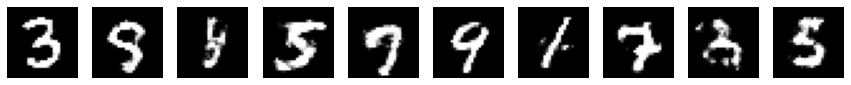

89 [D loss: 0.400964, acc: 79.69%] [G loss: 4.329683]


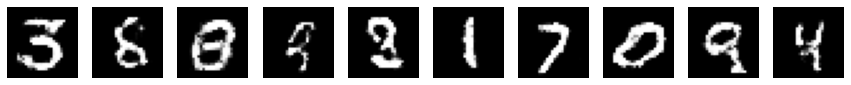

90 [D loss: 0.453502, acc: 82.29%] [G loss: 4.397089]


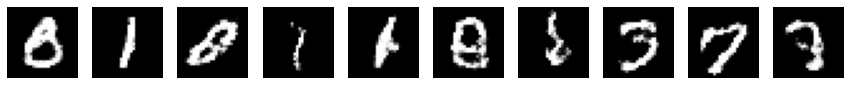

91 [D loss: 0.416775, acc: 79.69%] [G loss: 4.465631]


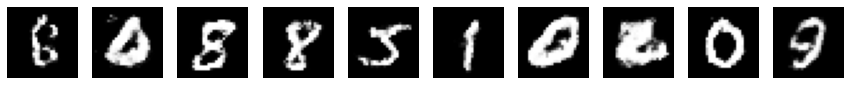

92 [D loss: 0.372018, acc: 85.94%] [G loss: 4.650016]


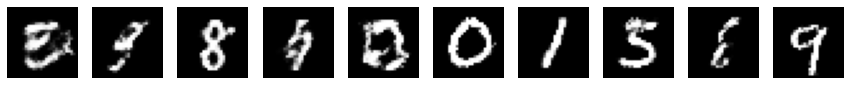

93 [D loss: 0.392788, acc: 85.94%] [G loss: 3.946748]


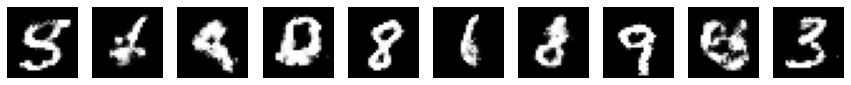

94 [D loss: 0.416137, acc: 84.38%] [G loss: 4.774304]


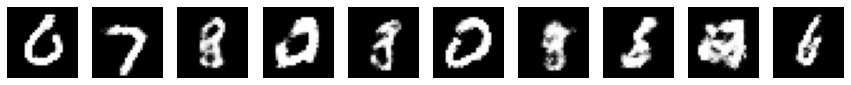

95 [D loss: 0.451706, acc: 79.17%] [G loss: 4.041090]


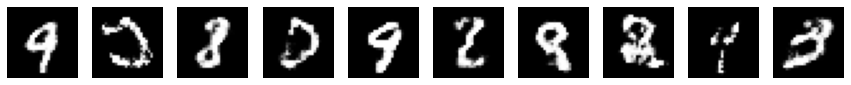

96 [D loss: 0.440412, acc: 79.69%] [G loss: 4.228278]


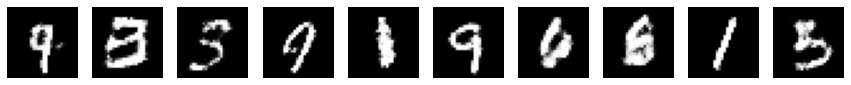

97 [D loss: 0.418654, acc: 76.04%] [G loss: 4.643777]


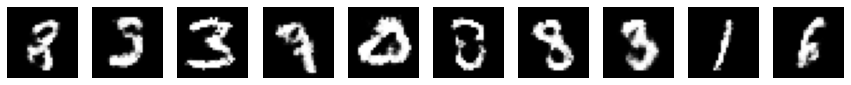

98 [D loss: 0.439207, acc: 76.56%] [G loss: 4.087704]


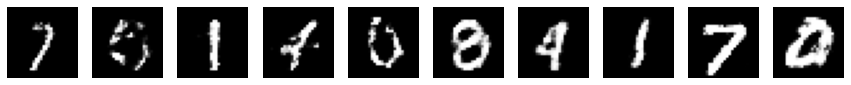

99 [D loss: 0.478983, acc: 78.12%] [G loss: 4.273481]


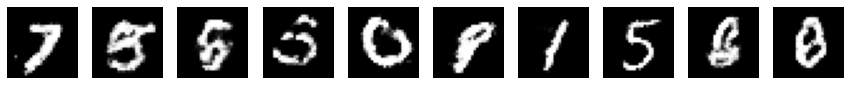

In [8]:
bigan = BIGAN()
bigan.train(epochs=100, batch_size=128, sample_interval=400)

In [9]:
X_train_enhanced = bigan.encoder.predict(X_train, batch_size=128)

X_test_enhanced = bigan.encoder.predict(X_test, batch_size=128)

In [10]:
np.save('x_train_enhanced_bigan.npy', X_train_enhanced)
np.save('x_test_enhanced_bigan.npy', X_test_enhanced)

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, learning_rate=70, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D = tsne.fit_transform(X_train_enhanced)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.010s...
[t-SNE] Computed neighbors for 60000 samples in 191.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

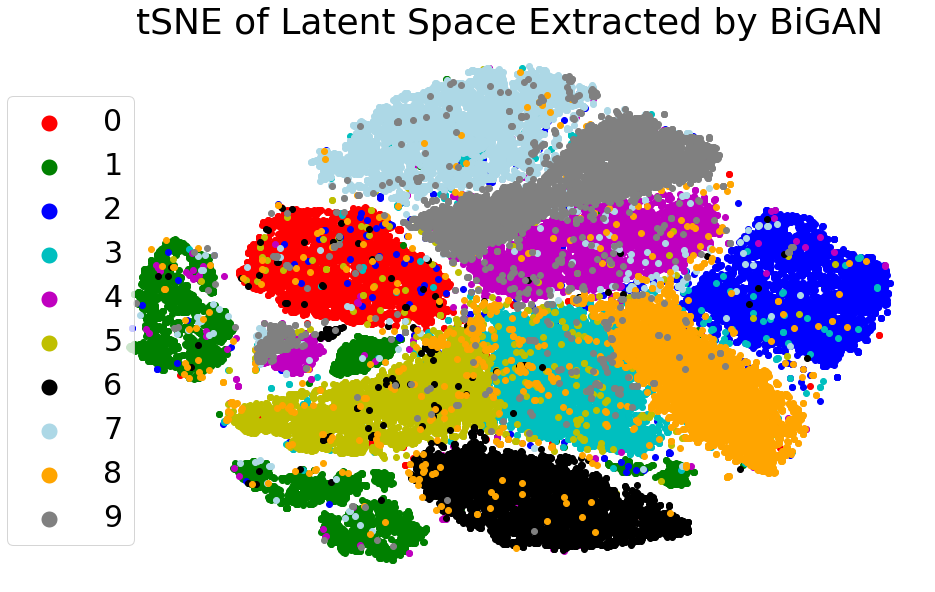

In [17]:
plt.figure(figsize=(15,10))
plt.title("tSNE of Latent Space Extracted by BiGAN")
plt.rcParams.update({'font.size': 30})
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightblue', 'orange', 'gray']

for i, c in zip(list(range(0, 10)), colors):
    idx = y_train==i
    plt.scatter(EX2D[y_train==i, 0], EX2D[y_train==i,1], c=c, label=str(i))
    
leg = plt.legend(bbox_to_anchor=(-0.1, 0.9), loc=2, borderaxespad=0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(10.0)
plt.axis('off')
plt.savefig(r'.\plots\tSNE_bigan.pdf')

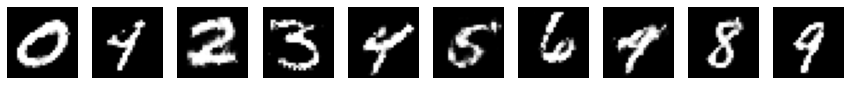

In [13]:
sampled_indices = [21, 59979, 25, 12, 59943, 11, 32, 29, 41, 22]
z_ = bigan.encoder.predict(X_train[sampled_indices])
x_reconstructed = bigan.generator.predict(z_)
gener = x_reconstructed.reshape(10, 28, 28)
fig, ax = plt.subplots(1, 10, figsize=(15,5))
for i in range(10):
    ax[i].imshow(gener[i], cmap='gray')
    ax[i].axis('off')
plt.savefig(r"C:\Users\pinar\OneDrive\Masaüstü\masterthesis\figures\g(e(x))\bigan_generator_output.png")
plt.show()